In [1]:
import os
import json
import torch
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
from datasets import find_padding_masks

In [2]:
transformer_model = TransformerEncoder(feat_dim=35,
                                    max_len=40,
                                    d_model=64, 
                                    n_heads=8, 
                                    num_layers=1,
                                    dim_feedforward=256, 
                                    dropout=0.1, 
                                    freeze=False)
transformer_model.float()

# Load pretrained weights 
transformer_model.load_state_dict(torch.load('../models/inputting_unity_norm.pt'))

<All keys matched successfully>

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 35 * 40, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        logits = self.fc2(x)
        return logits

In [4]:
cnn_model = CNNModel()
cnn_model

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=89600, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [5]:
class CombinedModel(nn.Module):
    def __init__(self, transformer_model, cnn_model):
        super(CombinedModel, self).__init__()
        self.transformer_model = transformer_model
        self.cnn_model = cnn_model

    def forward(self, x, padding_mask):
        transformer_output = self.transformer_model(x, padding_mask)
        transformed_output = transformer_output.unsqueeze(1)
        logits_output = self.cnn_model(transformed_output)
        return logits_output

In [6]:
main_model = CombinedModel(transformer_model, cnn_model)
main_model

CombinedModel(
  (transformer_model): TransformerEncoder(
    (project_inp): Linear(in_features=35, out_features=64, bias=True)
    (pos_enc): LearnablePositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (output_layer): Linear(in_features

In [15]:
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
print(data_indices['val_indices'])

[247, 56, 297, 114, 313, 446, 258, 43, 133, 246, 242, 383, 413, 67, 8, 336, 152, 342, 272, 225, 257, 454, 26, 304, 269, 227, 458, 118, 27, 60, 338, 193, 433, 74, 191, 182, 175, 285, 139, 162, 208, 341, 33, 298, 173, 386, 451, 5, 23, 130, 343, 92, 107, 165, 280, 28, 226, 255, 197, 161, 379, 14, 214, 164, 231, 97, 170, 428, 287, 15, 288, 37, 71, 362, 123, 144, 174, 32, 61, 302, 399, 59, 111, 237, 44, 402, 366, 141, 334, 312, 436, 440, 475, 474, 380, 364, 240]


In [8]:
main_model.eval()
x, _, _ = next(iter(train_dataloader))
padding_mask = find_padding_masks(x)
x = torch.nan_to_num(x) # replace nan with 0 (since needs to be processed by the model)
probabilities = main_model(x, padding_mask)
probabilities

tensor([[0.2484, 0.2286],
        [0.2265, 0.1931],
        [0.1994, 0.1556],
        [0.2204, 0.1553],
        [0.2171, 0.1671],
        [0.2285, 0.2240],
        [0.2230, 0.1962],
        [0.2366, 0.2181],
        [0.2256, 0.1924],
        [0.2259, 0.2230]], grad_fn=<AddmmBackward0>)

In [11]:
def train_and_validate_classifier(model, train_loader, test_loader, n_epoch)

    best_test_loss = 1e20
    running_batch_loss_train = []
    running_batch_loss_test = []
    save_path = '../models/classification_unity_norm.pt'

    for epoch in range(n_epoch):
        print(f"Epoch: {epoch + 1}")

        # Train loop 
        for x, _, y in train_loader:
            padding_mask = find_padding_masks(x)
            x = torch.nan_to_num(x).to(device)
            y_hat = main_model(x, padding_mask).to(device)
            optimizer.zero_grad()
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_batch_loss_train.append(loss.item())

        # Test loop
        for x, _, y in test_loader:
            padding_mask = find_padding_masks(x)
            x = torch.nan_to_num(x).to(device)
            y_hat = main_model(x, padding_mask).to(device)
            loss = criterion(y_hat, y)
            running_batch_loss_test.append(loss.item())

        # Save model if test loss is lower than best test loss
        if running_batch_loss_test[-1] < best_test_loss:
            best_test_loss = running_batch_loss_test[-1]
            torch.save(main_model.state_dict(), save_path)
            print(f"Saved model at epoch {epoch + 1}")

        # Print loss
        print(f"Train loss: {running_batch_loss_train[-1]}")
        print(f"Test loss: {running_batch_loss_test[-1]}")

    return running_batch_loss_train, running_batch_loss_test

n_epoch = 100
train_loader = train_dataloader
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(main_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_model.to(device)

train_loss, test_loss = train_and_validate_classifier(main_model, train_loader, train_loader, n_epoch)

Epoch: 1
tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1])


**Embeddings**

In [20]:
# Instantiate transformer model and load pretrained weights of best model on the classifciation task
main_model = CombinedModel(transformer_model, cnn_model)
main_model.load_state_dict(torch.load('../models/classification_standard_norm.pt'))
main_model.eval();

In [37]:
# Load trained weights of the transformer model

# Step 1: Create an instance of CombinedModel
transformer_model = TransformerEncoder(feat_dim=35,max_len=40,d_model=64,n_heads=8,num_layers=1,dim_feedforward=256,dropout=0.1,freeze=False).float()
cnn_model = CNNModel().float()
main_model = CombinedModel(transformer_model, cnn_model).float()

# Step 2: Load the weights for the entire combined model
main_model.load_state_dict(torch.load("../models/classification_standard_norm.pt"))

# Step 3: Remove the weights that belong to the cnn_model from the loaded state dict
state_dict = main_model.state_dict()
state_dict = {k: v for k, v in state_dict.items() if "cnn_model" not in k}

# Step 4: Load the modified state dict into the transformer_model
transformer_model.load_state_dict(state_dict, strict=False)

# Step 5: Set to eval mode
transformer_model.eval();

In [36]:
# Load train data
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='standard'), batch_size=1, shuffle=False, drop_last=False)

# Load validation data
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
val_indices = data_indices['val_indices']
val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=1, shuffle=False, drop_last=False)

In [36]:
import pandas as pd 
df = pd.read_csv(f'../data/long/{original_file_indx}.csv')
df.shape[0]

38

In [1]:
import os
import json
import torch
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
model = TransformerEncoder(feat_dim=35,
                           max_len=40,
                           d_model=35,
                           n_heads=7,
                           num_layers=1,
                           dim_feedforward=256,
                           dropout=0.1,
                           freeze=False).float()

In [3]:
inputs = torch.randn(1, 40, 35)
mask = torch.ones(1, 40).bool()
outputs, imbedding = model(inputs, mask)

In [4]:
outputs.shape, imbedding.shape

(torch.Size([1, 40, 35]), torch.Size([1, 40, 35]))

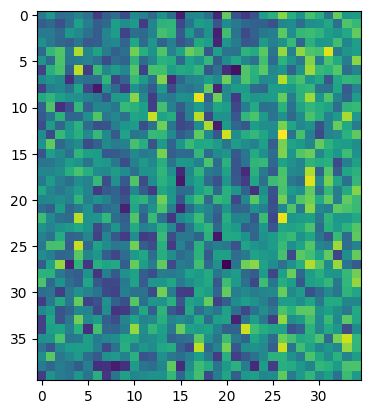

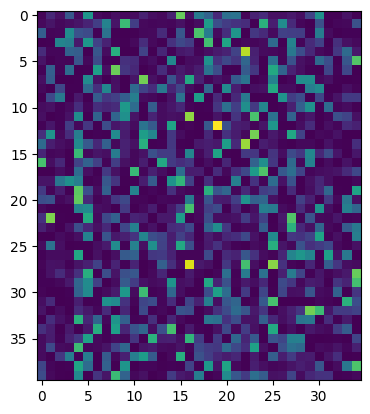

In [5]:
plt.imshow(outputs.detach().numpy()[0])
plt.show()

plt.imshow(imbedding.detach().numpy()[0])
plt.show()

**Create embedding dataset from trained transformer encoder**  
Must be the same format at original csv files

In [40]:
import os
import json
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
from datasets import find_padding_masks

In [48]:
# Get column names
df = pd.read_csv('../data/long/1.csv') # read in random file since all csv files have the same columns
features = df.columns.tolist()

In [49]:
# Load all data
indices = np.arange(0, 485, 1)
dataloader = DataLoader(MVTSDataset(indices, norm_type='standard'), batch_size=len(indices), shuffle=False, drop_last=False)
data, _, y = next(iter(dataloader))
print(data.shape, y)

torch.Size([485, 40, 35]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 

In [57]:
x = data[0].unsqueeze(0)
x.shape

torch.Size([1, 40, 35])

In [112]:
# Create the embeddings using the trained transformer model
transformer_model = TransformerEncoder(feat_dim=35,
                                       max_len=40,
                                       d_model=35,
                                       n_heads=7,
                                       num_layers=1,
                                       dim_feedforward=256,
                                       dropout=0.1,
                                       freeze=True).float()
transformer_model.eval();

indx = 0
for input, label in zip(data, y):
    label = label.item()
    input = input.unsqueeze(0)
    padding_mask = find_padding_masks(input)
    input = torch.nan_to_num(input)
    output, embedding = transformer_model(input, padding_mask)
    embedding = embedding.detach().numpy()[0]
    padding_mask = padding_mask.squeeze(0).detach().numpy()
    embedding = embedding[padding_mask]
    df = embedding_to_dataframe(embedding, features, label, indx)
    df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)
    df.rename(columns={'Unnamed: 0': ''}, inplace=True)
    df.to_csv(f'../data/embeddings/{indx}.csv', index=False)
    indx += 1
    break

torch.Size([1, 40, 35]) torch.Size([1, 40, 35])


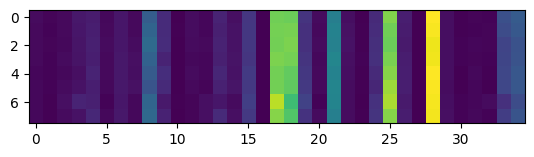

In [85]:
input = data[7].unsqueeze(0)
padding_mask = find_padding_masks(input)
input = torch.nan_to_num(input)
output, embedding = transformer_model(input, padding_mask)
embedding = embedding.detach().numpy()[0]
padding_mask = padding_mask.squeeze(0).detach().numpy()
embedding = embedding[padding_mask]

In [90]:
def embedding_to_dataframe(embedding, features, label, indx):
    """
    This function creates a pandas dataframe of the embeddings from transformer encoder that has been trained on the classifcation taks.
    The dataframe is of the same format as the original csv files.
    Args: embedding --> from trained transformer encoder ndarray(seq_len, d_model)
          features --> list of features from original csv file
          label --> Flare No-Flare binary label output from the dataloader 
          indx --> index of the original csv file         
    Output: pandas dataframe with the same format as the original csv files.
    """

    embedding = np.concatenate(
        (np.full((embedding.shape[0], 1), indx, dtype=int), embedding), axis=1) # add index column

    # add extra columns to match original csv file
    extra_cols = len(features) - embedding.shape[1] 
    extra_data = np.empty((embedding.shape[0], extra_cols))
    extra_data.fill(np.nan)
    modified_array = np.concatenate((embedding, extra_data), axis=1)

    # turn array into pandas dataframe and rename columns as well as add target values
    new_df = pd.DataFrame(modified_array, columns=features)
    new_df['R_VALUE'], new_df['XR_MAX'] = new_df['XR_MAX'], new_df['R_VALUE']
    new_df['target'] = label

    return new_df

In [17]:
df.head()

,Unnamed: 0,94,131,171,193,211,304,335,1600,1700,...,MEANJZH,TOTFY,MEANJZD,MEANALP,TOTFX,EPSY,EPSX,R_VALUE,XR_MAX,target
0,1,8.974219,29.204307,506.383286,818.701571,355.635094,105.700492,19.654783,77.338210,959.218468,...,0.012208,-1.082416e+23,0.050998,0.028371,-1.940120e+24,0.008031,0.143956,4.340293,4.854100e-07,1
1,1,10.126854,29.849536,496.012853,817.035740,356.629023,104.075087,20.269867,76.612126,963.786084,...,0.011820,-1.035303e+23,0.089647,0.027410,-1.934845e+24,0.007630,0.142551,4.338973,4.561938e-07,1
2,1,8.892889,27.052865,476.856401,792.896779,345.935345,96.576911,19.220694,75.617088,962.414683,...,0.011432,-9.881894e+22,0.128297,0.026448,-1.929571e+24,0.007229,0.141145,4.337653,4.269777e-07,1
3,1,8.569652,27.261664,483.389960,803.001028,349.442374,97.915371,19.269333,76.886881,959.575392,...,0.012075,-1.187114e+23,0.137501,0.027907,-1.899762e+24,0.008684,0.138957,4.346457,4.454338e-07,1
4,1,10.726769,30.501550,495.347490,828.010697,357.261581,101.980005,19.998163,77.086714,953.769573,...,0.012774,-1.399708e+23,0.145070,0.029499,-1.868590e+24,0.010242,0.136726,4.355824,4.665385e-07,1


**Grad-CAM**  
Problem is that not interpretable on the embeddings. Must either use CNN trained without transformer or make sure that the embedding discriminant region corresponds to that of the original mvts.

In [99]:
import os
import torch
import numpy as np
import pandas as pd
from captum.attr import GuidedGradCam
from torch.utils.data import Dataset, DataLoader
from models import TransformerEncoder, CNNModel, CombinedModel
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

In [173]:
class CNNDataset(Dataset):
    '''
    Outputs a tuple of (x, y) where x is a tensor of shape (batch, features, time) and y is a tensor of shape (1,)
    Normalization is done per sample and is a unity normalization, i.e., no intensity infomation.
    '''
    def __init__(self, indices):
        super(CNNDataset, self).__init__()
        self.indices = indices

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        index = self.indices[idx]
        df = pd.read_csv(f'../data/embeddings/{index}.csv')
        if len(df) < 40:
            padding = pd.DataFrame(np.nan, index=np.arange(40 - len(df)), columns=df.columns)
            df = pd.concat([padding, df])

        label = df["target"].values[-1].astype(np.int64)
        df = df.drop("target", axis=1)
        df = df.drop("Unnamed: 0", axis=1)
        df = df.drop("R_VALUE", axis=1)
        embedding = np.array(df.values, dtype=np.float32)
        embedding_norm = embedding.T
        embedding_norm = self.unity_based_normalization(embedding_norm)
        embedding_norm = embedding_norm.T
        embedding = torch.tensor(embedding, dtype=torch.float32)
        embedding = torch.nan_to_num(embedding, nan=0)
        embedding = embedding.unsqueeze(0)
        embedding_norm = torch.tensor(embedding_norm, dtype=torch.float32)
        embedding_norm = torch.nan_to_num(embedding_norm, nan=0)

        return embedding, embedding_norm, label
    
    @staticmethod
    def unity_based_normalization(data):
        '''
        Normalize each row of the data matrix by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
        Takes in arrays of shape (features, time)
        This is just for visulization purposes, the CNN eats the raw embeddings without a normalization
        '''
        # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
        # Get the maximum and minimum values of each row
        max_vals = np.nanmax(data, axis=1)
        min_vals = np.nanmin(data, axis=1)
        # Compute the range of each row, and add a small constant to avoid division by zero
        ranges = max_vals - min_vals
        eps = np.finfo(data.dtype).eps  # machine epsilon for the data type
        ranges[ranges < eps] = eps
        # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
        data = (data - min_vals[:, np.newaxis]) / ranges[:, np.newaxis]
        data = data + np.nanmax(data)
        data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
        return data

In [174]:
# Create a model instance of the CNN and load the pretrained weights

# Step 1: Create an instance of the CombinedModel
transformer_model = TransformerEncoder(feat_dim=35,max_len=40,d_model=35,n_heads=7,num_layers=1,dim_feedforward=256,dropout=0.1,freeze=True).float()
cnn_model = CNNModel().float()
main_model = CombinedModel(transformer_model, cnn_model).float()

# Step 2: Load the weights for the entire combined model
main_model.load_state_dict(torch.load("../models/classification_standard_norm.pt"))

# Step 3: Remove the weights that belong to the transformer model from the loaded state dict
state_dict = main_model.state_dict()
state_dict = {k: v for k, v in state_dict.items() if "transformer_model" not in k}

# Step 4: Load the modified state dict into the cnn_model
cnn_model.load_state_dict(state_dict, strict=False)

# Step 5: Set to eval mode
cnn_model.eval()

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=89600, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [228]:
# Load data 
Mydataset = CNNDataset(indices=[7])
train_dataloader = DataLoader(Mydataset, batch_size=1, shuffle=False)
embedding, embedding_norm, label = next(iter(train_dataloader))

In [229]:
# Create a GuidedGradCam object based on the model and the desired layer
guided_grad_cam = GuidedGradCam(cnn_model, cnn_model.conv2)

# Get the attribution mask
attribution_mask = guided_grad_cam.attribute(embedding.requires_grad_(), target=label.item()).detach()

/Users/brandonlpanos/gits/mvts_transformer/envmvts/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [230]:
torch.nanmean(attribution_mask)
attribution_mask.shape

torch.Size([1, 1, 40, 35])

/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_17266/1410792091.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_17266/1410792091.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


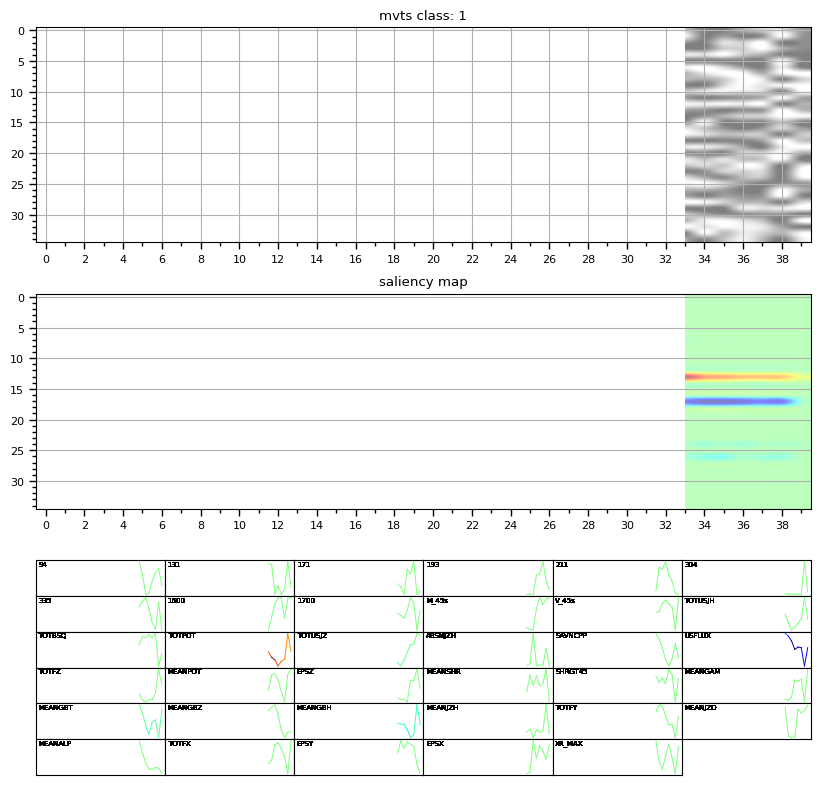

In [231]:
plt.rcParams['font.size'] = 8

name = '1'
class_name = str(label.detach().numpy().item())

dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
          'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
          'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
          'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']


embedding = embedding.squeeze().detach().numpy().copy().T
embedding_norm = embedding_norm.squeeze().detach().numpy().copy().T
attribution_mask = attribution_mask.squeeze().detach().numpy().copy().T

# nan out the padding
embedding[embedding==0] = np.nan
n_void = np.isnan(embedding[0]).sum()
attribution_mask[:,0:n_void] = np.nan
embedding_norm[embedding_norm==0] = np.nan


fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1, 1, 1], hspace=0.15, wspace=0.3)

# plot input mvt
ax1 = fig.add_subplot(gs[0:1, :])
ax1.set_title(f'mvts class: {class_name}')
ax1.imshow(embedding_norm, aspect='auto', cmap='gray', interpolation='spline16', alpha=0.5)
ax1.yaxis.grid(True, "major")
ax1.xaxis.grid(True, "major")
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)

# Plot saliency map
ax2 = fig.add_subplot(gs[1, :])
ax2.set_title('saliency map')
ax2.imshow(attribution_mask, aspect='auto', cmap='jet', alpha=0.5, interpolation='spline16')
ax2.yaxis.grid(True, "major")
ax2.xaxis.grid(False, "major")
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)

# Plot the light curves
gs2 = gridspec.GridSpecFromSubplotSpec(6, 6, subplot_spec=gs[2, 0:], wspace=0, hspace=0)
# Add the gridplot subplots
for i in range(6):
    for j in range(6):
        ind = (i * 6) + j
        if ind < len(dtypes):  # Check if index is within the range of dtypes
            ax = fig.add_subplot(gs2[i, j])
            # Handle NaN values in attribution_mask
            masked_mask = np.ma.masked_invalid(attribution_mask)
            # Normalize the masked_mask to range [0, 1]
            norm = mcolors.Normalize(vmin=masked_mask.min(), vmax=masked_mask.max())
            normalized_mask = norm(masked_mask)
            # Convert the normalized mask to RGB
            cmap = plt.cm.get_cmap('jet')
            rgb_colors = cmap(normalized_mask)
            light_curve = embedding[ind]
            light_curve_colors = rgb_colors[ind, :, :]
            for k, clr in enumerate(light_curve_colors):
                if k + 1 == 40: break
                x = [k, k+1]
                y = [light_curve[k], light_curve[k+1]]
                plt.plot(x, y, color=clr, linewidth=0.7)
                plt.text(0.02, 0.9, dtypes[ind], fontsize=5, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
                plt.xticks([])
                plt.yticks([])
                plt.xlim(0,40)
plt.tight_layout()
# plt.savefig(f'figs/{name}.png', bbox_inches='tight')
plt.show()
plt.close(fig)

In [167]:
# Load data 
Mydataset = CNNDataset(indices=[0])
train_dataloader = DataLoader(Mydataset, batch_size=1, shuffle=False)
embedding, embedding_norm, label = next(iter(train_dataloader))
embedding[embedding==0] = torch.nan
embedding_norm[embedding_norm==0] = torch.nan
print(label)

# Create a GuidedGradCam object based on the model and the desired layer
guided_grad_cam = GuidedGradCam(cnn_model, cnn_model.conv2)

# Get the attribution mask
attribution_mask = guided_grad_cam.attribute(embedding.requires_grad_(), target=label.item()).detach()

tensor([1])


/Users/brandonlpanos/gits/mvts_transformer/envmvts/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [168]:
attribution_mask.shape

torch.Size([1, 1, 40, 35])

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

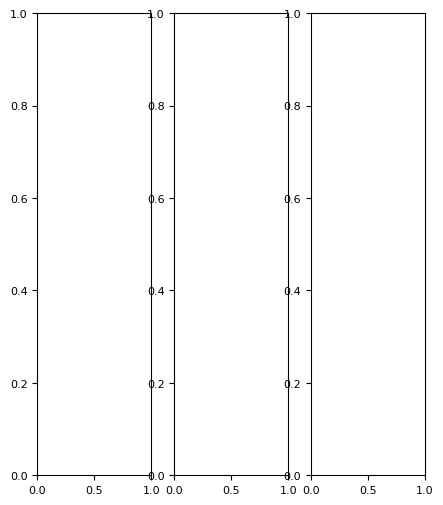

In [180]:
fig, axs = plt.subplots(1, 3, figsize=(5, 6))
axs[0].imshow(embedding[0, 0, :, :].detach().numpy(), aspect='auto', alpha=0.5, cmap='jet', interpolation='spline16')
axs[1].imshow(embedding_norm[0, 0, :, :].detach().numpy(), aspect='auto', alpha=0.5, cmap='jet', interpolation='spline16')
axs[2].imshow(attribution_mask[0, 0, :, :].detach().numpy() - attribution_mask[0, 0, :, :].numpy(), aspect='auto', alpha=0.5, cmap='jet', interpolation='spline16')
plt.tight_layout()
plt.show()